<a href="https://colab.research.google.com/github/ValentinoVizner/google_Colab/blob/master/Copy_of_lesson2_rf_interpretation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Important: This notebook will only work with fastai-0.7.x. Do not try to run any fastai-1.x code from this path in the repository because it will load fastai-0.7.x**

# Random Forest Model interpretation

In [1]:
!pip install fastai==0.7.0
!pip install "torchtext==0.2.3"


     |████████████████████████████████| 122kB 3.3MB/s 
     |████████████████████████████████| 496.4MB 31kB/s 
     |████████████████████████████████| 1.5MB 32.1MB/s 
  Created wheel for bcolz: filename=bcolz-1.2.1-cp36-cp36m-linux_x86_64.whl size=2667142 sha256=8bf002813c49790f7080495cb76b7e68ab5343ecd3064017ad297cac2ddd5794
  Stored in directory: /root/.cache/pip/wheels/9f/78/26/fb8c0acb91a100dc8914bf236c4eaa4b207cb876893c40b745
Successfully built bcolz
ERROR: torchvision 0.4.2 has requirement torch==1.3.1, but you'll have torch 0.3.1 which is incompatible.
  Found existing installation: torch 1.3.1
    Uninstalling torch-1.3.1:
      Successfully uninstalled torch-1.3.1
  Found existing installation: fastai 1.0.59
    Uninstalling fastai-1.0.59:
      Successfully uninstalled fastai-1.0.59
     |████████████████████████████████| 51kB 2.0MB/s 
  Created wheel for torchtext: filename=torchtext-0.2.3-cp36-none-any.whl size=40134 sha256=057daec9c0b31af8976ba15673493598f1fefa21b2b8b860df

In [3]:
import os
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
os.environ['valentinovizner'] = "2b6a47d2c04ff985d1e06b4e258b6142" # username from the json file os.environ['KAGGLEKEY'] = "xxxxxxxxxxxxxxxxxxxxxxxxxxxx" # key from the json file
!kaggle competitions download -c bluebook-for-bulldozers -p /content/data/bulldozers # api copied from kaggle

Saving kaggle.json to kaggle.json
  0% 0.00/291k [00:00<?, ?B/s]
100% 291k/291k [00:00<00:00, 46.9MB/s]
  0% 0.00/316k [00:00<?, ?B/s]
100% 316k/316k [00:00<00:00, 42.9MB/s]
  0% 0.00/10.8k [00:00<?, ?B/s]
100% 10.8k/10.8k [00:00<00:00, 9.28MB/s]
  0% 0.00/207k [00:00<?, ?B/s]
100% 207k/207k [00:00<00:00, 64.2MB/s]
 71% 5.00M/7.06M [00:00<00:00, 44.5MB/s]
100% 7.06M/7.06M [00:00<00:00, 44.9MB/s]
 73% 5.00M/6.85M [00:00<00:00, 49.6MB/s]
100% 6.85M/6.85M [00:00<00:00, 43.8MB/s]
  0% 0.00/192k [00:00<?, ?B/s]
100% 192k/192k [00:00<00:00, 165MB/s]
  0% 0.00/338k [00:00<?, ?B/s]
100% 338k/338k [00:00<00:00, 106MB/s]
 97% 9.00M/9.28M [00:00<00:00, 29.1MB/s]
100% 9.28M/9.28M [00:00<00:00, 26.7MB/s]
  0% 0.00/297k [00:00<?, ?B/s]
100% 297k/297k [00:00<00:00, 97.6MB/s]
 53% 5.00M/9.38M [00:00<00:00, 37.2MB/s]
100% 9.38M/9.38M [00:00<00:00, 59.9MB/s]
  0% 0.00/5.01M [00:00<?, ?B/s]
100% 5.01M/5.01M [00:00<00:00, 46.2MB/s]
  0% 0.00/209k [00:00<?, ?B/s]
100% 209k/209k [00:00<00:00, 186MB/s]
 52% 

In [4]:
%load_ext autoreload
%autoreload 2
!unzip /content/data/bulldozers/"*.zip" -d /content/data/bulldozers/unzipped
#!7za x -y "data/bulldozers/*.7z" -o/data/bulldozers/unzipped
PATH = "data/bulldozers/unzipped/"

Archive:  /content/data/bulldozers/Valid.zip
  inflating: /content/data/bulldozers/unzipped/Valid.csv  

Archive:  /content/data/bulldozers/Train.zip
  inflating: /content/data/bulldozers/unzipped/Train.csv  

Archive:  /content/data/bulldozers/Test.csv.zip
  inflating: /content/data/bulldozers/unzipped/Test.csv  

Archive:  /content/data/bulldozers/TrainAndValid.csv.zip
  inflating: /content/data/bulldozers/unzipped/TrainAndValid.csv  

Archive:  /content/data/bulldozers/TrainAndValid.zip
replace /content/data/bulldozers/unzipped/TrainAndValid.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/data/bulldozers/unzipped/TrainAndValid.csv  

Archive:  /content/data/bulldozers/Valid.csv.zip
  inflating: /content/data/bulldozers/unzipped/Valid.csv  

Archive:  /content/data/bulldozers/Machine_Appendix.csv.zip
  inflating: /content/data/bulldozers/unzipped/Machine_Appendix.csv  

7 archives were successfully processed.


In [0]:
%matplotlib inline


from fastai.imports import *
from fastai.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics

df_raw = pd.read_csv(f'{PATH}Train.csv', low_memory=False, 
                     parse_dates=["saledate"])
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)
df_raw.SalePrice = np.log(df_raw.SalePrice)
add_datepart(df_raw, 'saledate')
train_cats(df_raw)
df_raw.UsageBand.cat.set_categories(['High', 'Medium', 'Low'], ordered=True, inplace=True)
df_raw.UsageBand = df_raw.UsageBand.cat.codes
os.makedirs('tmp', exist_ok=True)
df_raw.to_feather('tmp/bulldozers-raw')

In [0]:
set_plot_sizes(12,14,16)

## 1.1 Load in our data from last lesson

In [0]:
PATH = "data/bulldozers/"
nas = {}
df_raw = pd.read_feather('tmp/bulldozers-raw')
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice', na_dict=nas)

In [0]:
def split_vals(a,n): 
    return a[:n], a[n:]

n_valid = 12000
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(df_raw, n_trn)

In [0]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [10]:
df_raw

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed
0,1139246,11.097410,999089,3157,121,3.0,2004,68.0,2,521D,521,D,NaN,NaN,NaN,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,NaN,EROPS w AC,None or Unspecified,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional,2006,11,46,16,3,320,False,False,False,False,False,False,1163635200
1,1139248,10.950807,117657,77,121,3.0,1996,4640.0,2,950FII,950,F,II,NaN,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,NaN,EROPS w AC,None or Unspecified,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,23.5,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional,2004,3,13,26,4,86,False,False,False,False,False,False,1080259200
2,1139249,9.210340,434808,7009,121,3.0,2001,2838.0,0,226,226,NaN,NaN,NaN,NaN,Skid Steer Loader - 1351.0 to 1601.0 Lb Operat...,New York,SSL,Skid Steer Loaders,NaN,OROPS,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,None or Unspecified,Standard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2004,2,9,26,3,57,False,False,False,False,False,False,1077753600
3,1139251,10.558414,1026470,332,121,3.0,2001,3486.0,0,PC120-6E,PC120,NaN,-6E,NaN,Small,"Hydraulic Excavator, Track - 12.0 to 14.0 Metr...",Texas,TEX,Track Excavators,NaN,EROPS w AC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011,5,20,19,3,139,False,False,False,False,False,False,1305763200
4,1139253,9.305651,1057373,17311,121,3.0,2007,722.0,1,S175,S175,NaN,NaN,NaN,NaN,Skid Steer Loader - 1601.0 to 1751.0 Lb Operat...,New York,SSL,Skid Steer Loaders,NaN,EROPS,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,None or Unspecified,Standard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2009,7,30,23,3,204,False,False,False,False,False,False,1248307200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401120,6333336,9.259131,1840702,21439,149,1.0,2005,NaN,-1,35NX2,35,NX,2,NaN,Mini,"Hydraulic Excavator, Track - 3.0 to 4.0 Metric...",Maryland,TEX,Track Excavators,NaN,EROPS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,NaN,NaN,NaN,Steel,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN,2011,11,44,2,2,306,False,False,False,False,False,False,1320192000
401121,6333337,9.305651,1830472,21439,149,1.0,2005,NaN,-1,35NX2,35,NX,2,NaN,Mini,"Hydraulic Excavator, Track - 3.0 to 4.0 Metric...",Maryland,TEX,Track Excavators,NaN,EROPS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,NaN,NaN,NaN,NaN,NaN,None or Unspecified,NaN,NaN,NaN,Steel,None or Unspecified,None or Unspecified,N

# Confidence based on tree variance

For model interpretation, there's no need to use the full dataset on each tree - using a subset will be both faster, and also provide better interpretability (since an overfit model will not provide much variance across trees).

In [0]:
set_rf_samples(50000)

In [12]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20600499775269898, 0.25157968371319867, 0.9113067969215664, 0.8869685997942558, 0.8942251273545863]


We saw how the model averages predictions across the trees to get an estimate - but how can we know the confidence of the estimate? One simple way is to use the standard deviation of predictions, instead of just the mean. This tells us the *relative* confidence of predictions - that is, for rows where the trees give very different results, you would want to be more cautious of using those results, compared to cases where they are more consistent. Using the same example as in the last lesson when we looked at bagging:

In [13]:
%time preds = np.stack([t.predict(X_valid) for t in m.estimators_])
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 1.48 s, sys: 65.8 ms, total: 1.55 s
Wall time: 1.55 s


(9.320386472744124, 0.32525877438627687)

When we use python to loop through trees like this, we're calculating each in series, which is slow! We can use parallel processing to speed things up:

In [14]:
def get_preds(t): return t.predict(X_valid)
%time preds = np.stack(parallel_trees(m, get_preds))
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 108 ms, sys: 130 ms, total: 238 ms
Wall time: 1.68 s


(9.320386472744124, 0.32525877438627687)

We can see that different trees are giving different estimates this this auction. In order to see how prediction confidence varies, we can add this into our dataset.

In [0]:
??parallel_trees

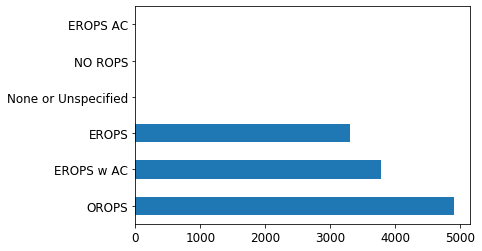

In [16]:
x = raw_valid.copy()
x['pred_std'] = np.std(preds, axis=0)
x['pred'] = np.mean(preds, axis=0)
x.Enclosure.value_counts().plot.barh();

In [17]:
flds = ['Enclosure', 'SalePrice', 'pred', 'pred_std']
enc_summ = x[flds].groupby('Enclosure', as_index=False).mean()
enc_summ

,Enclosure,SalePrice,pred,pred_std
0,EROPS,9.849178,9.829520,0.277544
1,EROPS AC,NaN,NaN,NaN
2,EROPS w AC,10.623971,10.566212,0.284961
3,NO ROPS,NaN,NaN,NaN
4,None or Unspecified,NaN,NaN,NaN
5,OROPS,9.682064,9.682085,0.222918


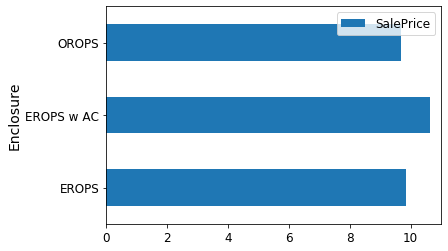

In [18]:
enc_summ = enc_summ[~pd.isnull(enc_summ.SalePrice)]
enc_summ.plot('Enclosure', 'SalePrice', 'barh', xlim=(0,11));

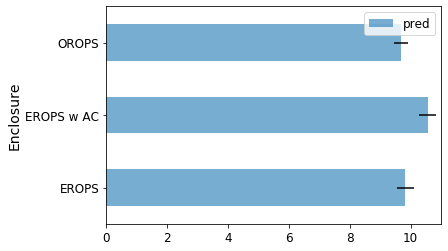

In [19]:
enc_summ.plot('Enclosure', 'pred', 'barh', xerr='pred_std', alpha=0.6, xlim=(0,11));

*Question*: Why are the predictions nearly exactly right, but the error bars are quite wide?

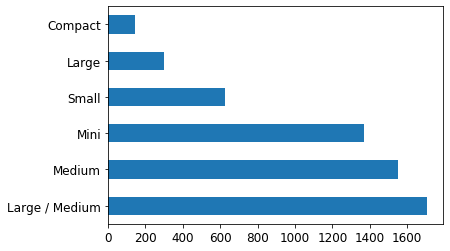

In [20]:
raw_valid.ProductSize.value_counts().plot.barh();

In [21]:
flds = ['ProductSize', 'SalePrice', 'pred', 'pred_std']
summ = x[flds].groupby(flds[0]).mean()
summ

,SalePrice,pred,pred_std
ProductSize,,,
Compact,9.735093,9.875733,0.347734
Large,10.470589,10.357622,0.378275
Large / Medium,10.691871,10.644553,0.297312
Medium,10.681511,10.599258,0.314388
Mini,9.535147,9.563506,0.243646
Small,10.324448,10.307568,0.316336


In [22]:
(summ.pred_std/summ.pred).sort_values(ascending=False)

ProductSize
Large             0.036521
Compact           0.035211
Small             0.030690
Medium            0.029661
Large / Medium    0.027931
Mini              0.025477
dtype: float64

# Feature importance

It's not normally enough to just to know that a model can make accurate predictions - we also want to know *how* it's making predictions. The most important way to see this is with *feature importance*.

In [0]:
fi = rf_feat_importance(m, df_trn)
fi[:10] # top 10

,cols,imp
5,YearMade,0.172311
13,ProductSize,0.096268
37,Coupler_System,0.089131
14,fiProductClassDesc,0.085196
38,Grouser_Tracks,0.060195
2,ModelID,0.056252
63,saleElapsed,0.051014
39,Hydraulics_Flow,0.046759
19,Enclosure,0.041794
10,fiSecondaryDesc,0.040978


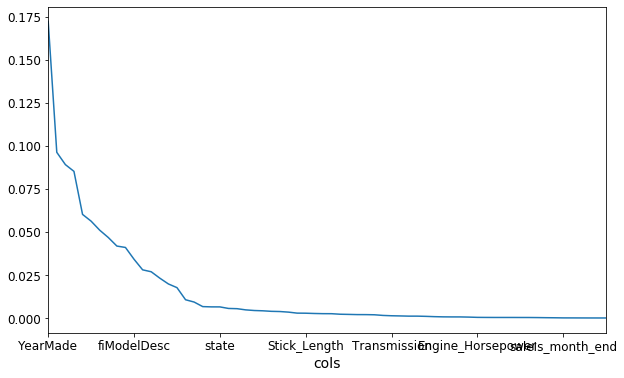

In [0]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

In [0]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

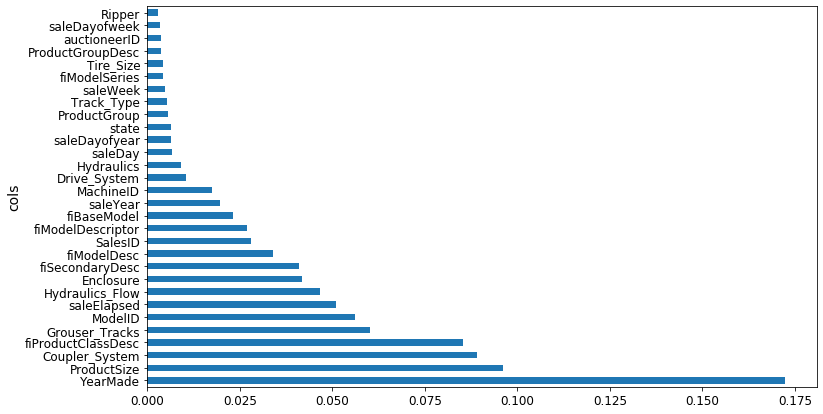

In [0]:
plot_fi(fi[:30]);

In [0]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)

23

In [0]:
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [0]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.2070568339608893, 0.245756070035644, 0.9103987714957572, 0.8921409772887273, 0.8942127273584984]


So we can see that removing the "unimportant" columns/features we ge even a bit better results:

*   Before: [0.2059863895709608, 0.24964937893112824, 0.9113228192969423, 0.8886964659784915, 0.8943320441904222]
*   After: [0.2074818037085201, 0.24521734625110508, 0.9100305934765606, 0.8926133361879791, 0.8935246037294933]



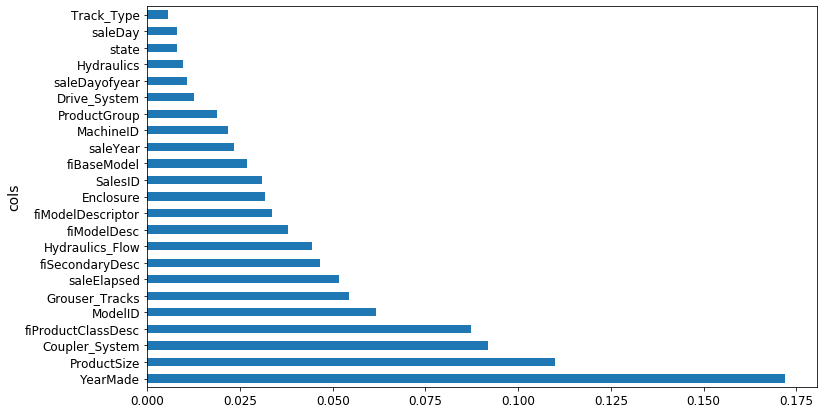

In [0]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi);

## One-hot encoding

proc_df's optional *max_n_cat* argument will turn some categorical variables into new columns.

For example, the column **ProductSize** which has 6 categories:

* Large
* Large / Medium
* Medium
* Compact
* Small
* Mini

gets turned into 6 new columns:

* ProductSize_Large
* ProductSize_Large / Medium
* ProductSize_Medium
* ProductSize_Compact
* ProductSize_Small
* ProductSize_Mini

and the column **ProductSize** gets removed.

It will only happen to columns whose number of categories is no bigger than the value of the *max_n_cat* argument.

Now some of these new columns may prove to have more important features than in the earlier situation, where all categories were in one column.

In [0]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)

m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20706687730012024, 0.25270915029625346, 0.9103900790286602, 0.8859514130022992, 0.8926904680440075]


In this case, One Hot Encoding with max_n_cats made it a bit WORSE!
</br>
That is not always the case it depends on the dataset, data, etc.
</br>
</br>
</br>

But what it DID do is it changed **Featuer Importance**

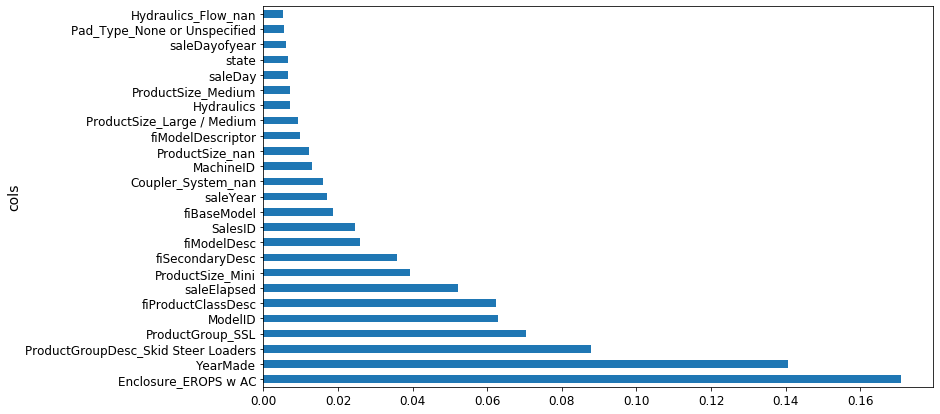

In [0]:
fi = rf_feat_importance(m, df_trn2)
plot_fi(fi[:25]);

 SO Jeremy always advise to do **One Hot Encoding** and see what you get.
 </br>
 Also he says he mostly uses 6-7 max_n_cats, but also advises us to try going as high as possible so our code doesn't run *forever*.

# Removing redundant features

One thing that makes this harder to interpret is that there seem to be some variables with very similar meanings. Let's try to remove redundent features.

In [0]:
from scipy.cluster import hierarchy as hc

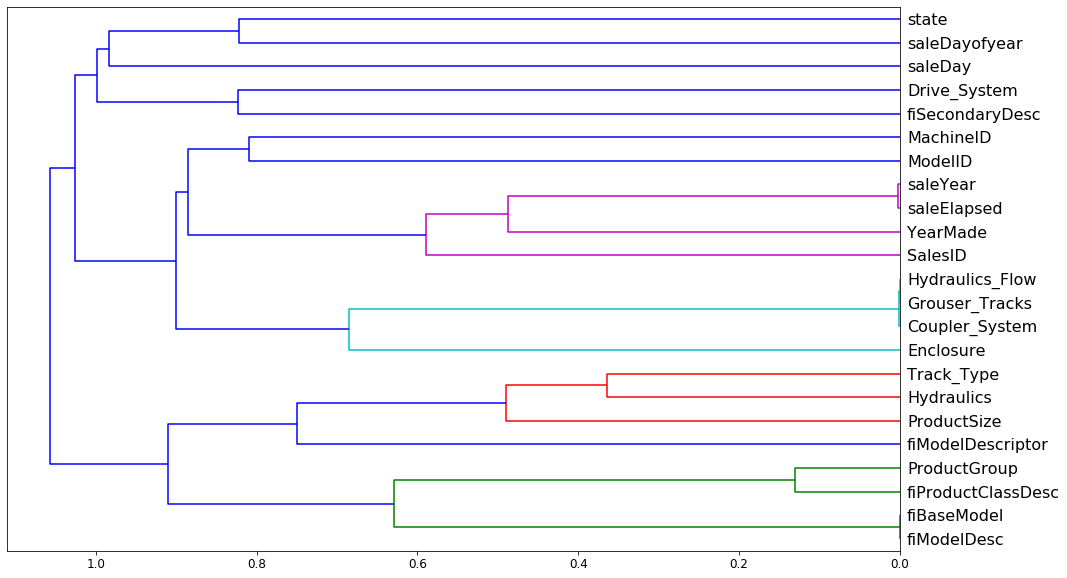

In [0]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

Let's try removing some of these related features to see if the model can be simplified without impacting the accuracy.

In [0]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=30, min_samples_leaf=5, max_features=0.6, n_jobs=-1, oob_score=True)
    x, _ = split_vals(df, n_trn)
    m.fit(x, y_train)
    return m.oob_score_

Here's our baseline.

In [0]:
get_oob(df_keep)

0.88999425494301454

Now we try removing each variable one at a time.

In [0]:
for c in ('saleYear', 'saleElapsed', 'fiModelDesc', 'fiBaseModel', 'Grouser_Tracks', 'Coupler_System'):
    print(c, get_oob(df_keep.drop(c, axis=1)))

saleYear 0.889037446375
saleElapsed 0.886210803445
fiModelDesc 0.888540591321
fiBaseModel 0.88893958239
Grouser_Tracks 0.890385236272
Coupler_System 0.889601052658


It looks like we can try one from each group for removal. Let's see what that does.

In [0]:
to_drop = ['saleYear', 'fiBaseModel', 'Grouser_Tracks']
get_oob(df_keep.drop(to_drop, axis=1))

0.88858458047200739

Looking good! Let's use this dataframe from here. We'll save the list of columns so we can reuse it later.

In [0]:
df_keep.drop(to_drop, axis=1, inplace=True)
X_train, X_valid = split_vals(df_keep, n_trn)

In [0]:
np.save('tmp/keep_cols.npy', np.array(df_keep.columns))

In [0]:
keep_cols = np.load('tmp/keep_cols.npy')
df_keep = df_trn[keep_cols]

And let's see how this model looks on the full dataset.

In [0]:
reset_rf_samples()

In [0]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.12615142089579687, 0.22781819082173235, 0.96677727309424211, 0.90731173105384466, 0.9084359846323049]


# Partial dependence

In [24]:
!pip install pdpbox
from pdpbox import pdp
from plotnine import *

     |████████████████████████████████| 57.7MB 83kB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.0-cp36-none-any.whl size=57690723 sha256=6d65ab62b7af72315595105fb2059b14aa960e0e6021ab76c20f00ca6a6fc502
  Stored in directory: /root/.cache/pip/wheels/7d/08/51/63fd122b04a2c87d780464eeffb94867c75bd96a64d500a3fe
Successfully built pdpbox


In [0]:
set_rf_samples(50000)

This next analysis will be a little easier if we use the 1-hot encoded categorical variables, so let's load them up again.

In [0]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train);

In [28]:
plot_fi(rf_feat_importance(m, df_trn2)[:10]);

NameError: ignored

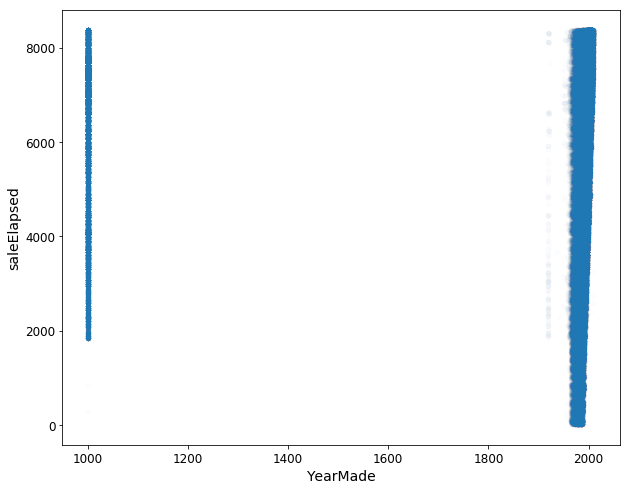

In [0]:
df_raw.plot('YearMade', 'saleElapsed', 'scatter', alpha=0.01, figsize=(10,8));

Here we can see that we have some vehicles sold in year 1000, which is odd, we better see with the ones who gave us data what is this about.
</br>
so we can probably exclude those made in 1000

In [0]:
x_all = get_sample(df_raw[df_raw.YearMade>1930], 500)

in code up we take the ones made in year bigget then 1930.
</br>
Also we selected only 500 samples because we don't need to plot all data.

     |████████████████████████████████| 9.2MB 3.4MB/s 


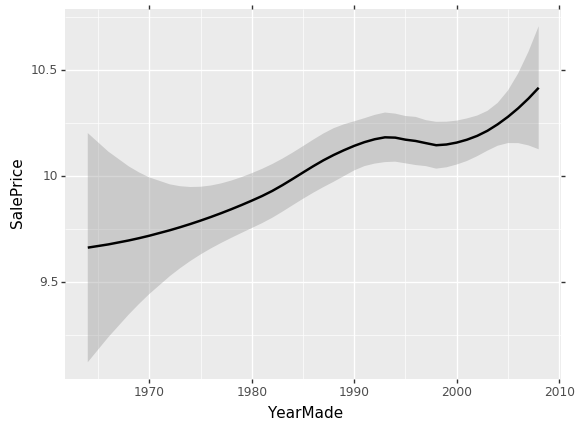

<ggplot: (-9223363262227788912)>

In [31]:
!pip install scikit-misc
ggplot(x_all, aes('YearMade', 'SalePrice'))+stat_smooth(se=True, method='loess') # se = standard error, loess = locally weighted regression
# With Plus we add to CHART in ggplot, in this case SMOOTHER

In [0]:
x = get_sample(X_train[X_train.YearMade>1930], 500)

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fb015bcb7b8>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fb016f6c278>})

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


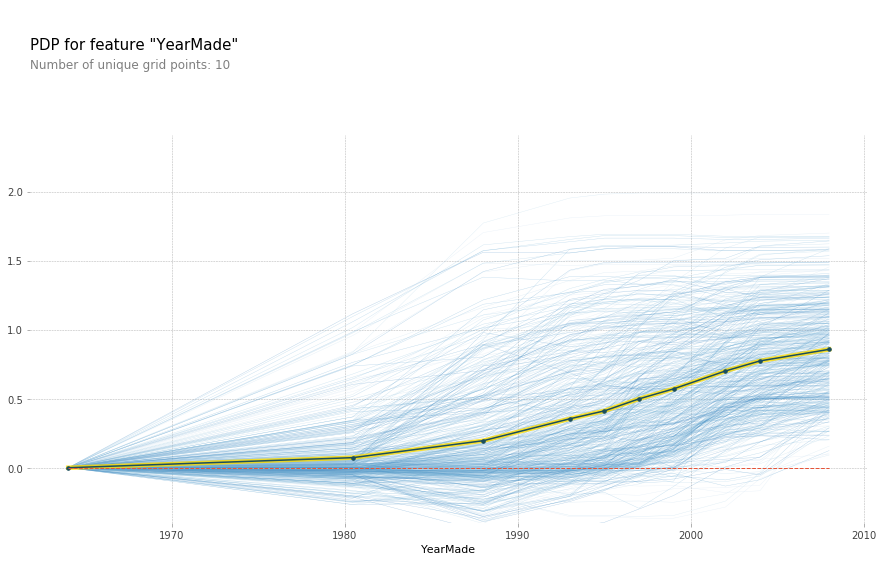

In [47]:
def plot_pdp(feat_name, clusters=None):
#feat_name = feat_name or feat
    p = pdp.pdp_isolate(m, x, feature=feat_name, model_features=x.columns)
    return pdp.pdp_plot(p, feat_name, plot_lines=True,
                   cluster=clusters is not None, n_cluster_centers=clusters)
plot_pdp(feat_name='YearMade')

In [37]:
plot_pdp('YearMade')

TypeError: ignored

In [35]:
plot_pdp('YearMade', clusters=5)

TypeError: ignored

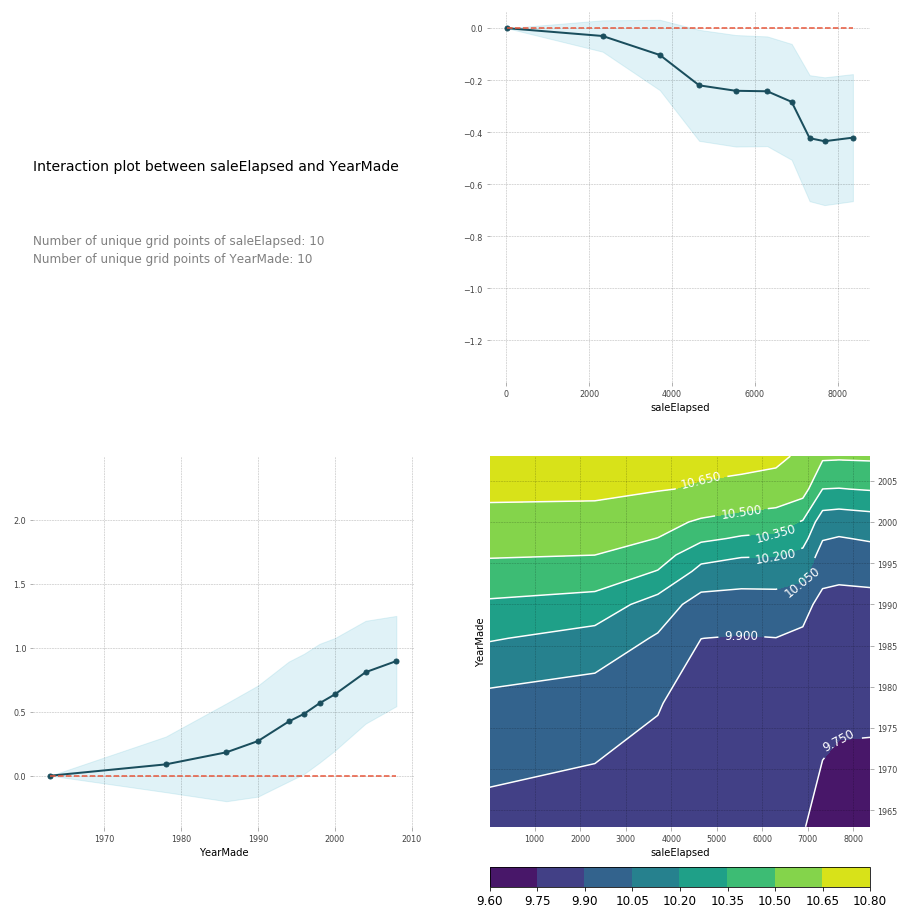

In [0]:
feats = ['saleElapsed', 'YearMade']
p = pdp.pdp_interact(m, x, feats)
pdp.pdp_interact_plot(p, feats)

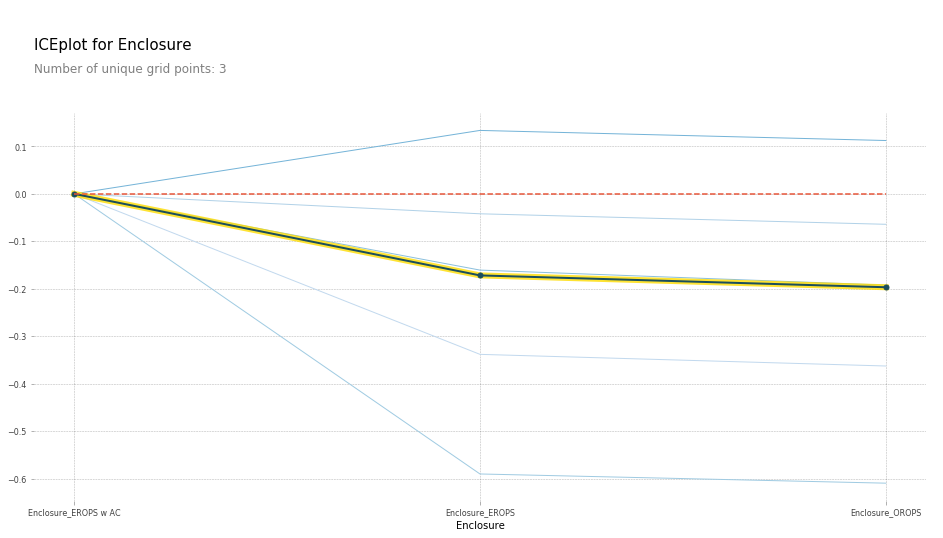

In [0]:
plot_pdp(['Enclosure_EROPS w AC', 'Enclosure_EROPS', 'Enclosure_OROPS'], 5, 'Enclosure')

In [0]:
df_raw.YearMade[df_raw.YearMade<1950] = 1950
df_keep['age'] = df_raw['age'] = df_raw.saleYear-df_raw.YearMade

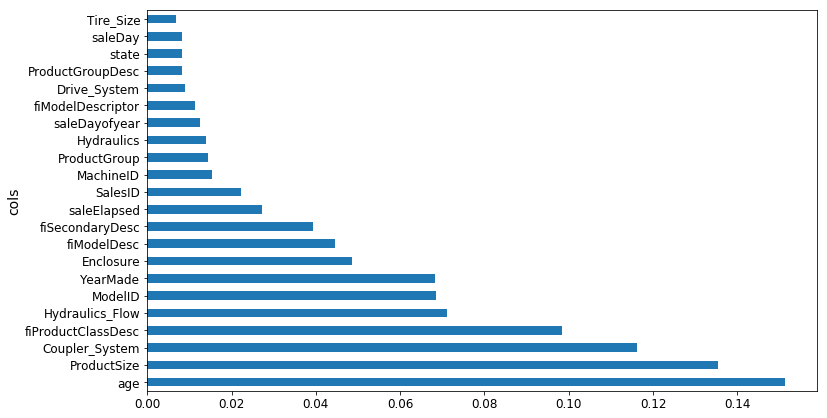

In [0]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train)
plot_fi(rf_feat_importance(m, df_keep));

# Tree interpreter

In [0]:
from treeinterpreter import treeinterpreter as ti

In [0]:
df_train, df_valid = split_vals(df_raw[df_keep.columns], n_trn)

In [0]:
row = X_valid.values[None,0]; row

array([[4364751, 2300944, 665, 172, 1.0, 1999, 3726.0, 3, 3232, 1111, 0, 63, 0, 5, 17, 35, 4, 4, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 12, 0, 0, 0, 0, 0, 3, 0, 0, 0, 2, 19, 29, 3, 2, 1, 0, 0, 0, 0, 0, 2010, 9, 37,
        16, 3, 259, False, False, False, False, False, False, 7912, False, False]], dtype=object)

In [0]:
prediction, bias, contributions = ti.predict(m, row)

In [0]:
prediction[0], bias[0]

(9.1909688098736275, 10.10606580677884)

In [0]:
idxs = np.argsort(contributions[0])

In [0]:
[o for o in zip(df_keep.columns[idxs], df_valid.iloc[0][idxs], contributions[0][idxs])]

[('ProductSize', 'Mini', -0.54680742853695008),
 ('age', 11, -0.12507089451852943),
 ('fiProductClassDesc',
  'Hydraulic Excavator, Track - 3.0 to 4.0 Metric Tons',
  -0.11143111128570773),
 ('fiModelDesc', 'KX1212', -0.065155113754146801),
 ('fiSecondaryDesc', nan, -0.055237427792181749),
 ('Enclosure', 'EROPS', -0.050467175593900217),
 ('fiModelDescriptor', nan, -0.042354676935508852),
 ('saleElapsed', 7912, -0.019642242073500914),
 ('saleDay', 16, -0.012812993479652724),
 ('Tire_Size', nan, -0.0029687660942271598),
 ('SalesID', 4364751, -0.0010443985823001434),
 ('saleDayofyear', 259, -0.00086540581130196688),
 ('Drive_System', nan, 0.0015385818526195915),
 ('Hydraulics', 'Standard', 0.0022411701338458821),
 ('state', 'Ohio', 0.0037587658190299409),
 ('ProductGroupDesc', 'Track Excavators', 0.0067688906745931197),
 ('ProductGroup', 'TEX', 0.014654732626326661),
 ('MachineID', 2300944, 0.015578052196894499),
 ('Hydraulics_Flow', nan, 0.028973749866174004),
 ('ModelID', 665, 0.0383074

In [0]:
contributions[0].sum()

-0.7383536391949419

# Extrapolation

In [0]:
df_ext = df_keep.copy()
df_ext['is_valid'] = 1
df_ext.is_valid[:n_trn] = 0
x, y, nas = proc_df(df_ext, 'is_valid')

In [0]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.99998753505765037

In [0]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
9,SalesID,0.764744
5,saleElapsed,0.146162
11,MachineID,0.077919
8,fiModelDesc,0.002931
20,saleDayofyear,0.002569
0,YearMade,0.002358
22,age,0.001202
4,ModelID,0.000664
6,fiSecondaryDesc,0.000361
1,Coupler_System,0.000208


In [0]:
feats=['SalesID', 'saleElapsed', 'MachineID']

In [0]:
(X_train[feats]/1000).describe()

,SalesID,saleElapsed,MachineID
count,389125.000000,389125.000000,389125.000000
mean,1800.452485,5.599522,1206.796148
std,595.627288,2.087862,430.850552
min,1139.246000,0.000000,0.000000
25%,1413.348000,4.232000,1087.016000
50%,1632.093000,6.176000,1273.859000
75%,2210.453000,7.328000,1458.661000
max,4364.741000,8.381000,2313.821000


In [0]:
(X_valid[feats]/1000).describe()

,SalesID,saleElapsed,MachineID
count,12000.000000,12000.000000,12000.000000
mean,5786.967651,8.166793,1578.049709
std,836.899608,0.289098,589.497173
min,4364.751000,6.638000,0.830000
25%,4408.580750,8.197000,1271.225250
50%,6272.538500,8.276000,1825.317000
75%,6291.792250,8.338000,1907.858000
max,6333.342000,8.382000,2486.330000


In [0]:
x.drop(feats, axis=1, inplace=True)

In [0]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.9789018385789966

In [0]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
19,age,0.233626
0,YearMade,0.188127
17,saleDayofyear,0.157429
4,ModelID,0.077623
7,fiModelDesc,0.061301
15,saleDay,0.056252
14,state,0.055201
3,fiProductClassDesc,0.035131
5,fiSecondaryDesc,0.023661
6,Enclosure,0.022409


In [0]:
set_rf_samples(50000)

In [0]:
feats=['SalesID', 'saleElapsed', 'MachineID', 'age', 'YearMade', 'saleDayofyear']

In [0]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.21136509778791376, 0.2493668921196425, 0.90909393040946562, 0.88894821098056087, 0.89255408392415925]


In [0]:
for f in feats:
    df_subs = df_keep.drop(f, axis=1)
    X_train, X_valid = split_vals(df_subs, n_trn)
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(X_train, y_train)
    print(f)
    print_score(m)

SalesID
[0.20918653475938534, 0.2459966629213187, 0.9053273181678706, 0.89192968797265737, 0.89245205174299469]
saleElapsed
[0.2194124612957369, 0.2546442621643524, 0.90358104739129086, 0.8841980790762114, 0.88681881032219145]
MachineID
[0.206612984511148, 0.24446409479358033, 0.90312476862123559, 0.89327205732490311, 0.89501553584754967]
age
[0.21317740718919814, 0.2471719147150774, 0.90260198977488226, 0.89089460707372525, 0.89185129799503315]
YearMade
[0.21305398932040326, 0.2534570148977216, 0.90555219348567462, 0.88527538596974953, 0.89158854973045432]
saleDayofyear
[0.21320711524847227, 0.24629839782893828, 0.90881970943169987, 0.89166441133215968, 0.89272793857941679]


In [0]:
reset_rf_samples()

In [0]:
df_subs = df_keep.drop(['SalesID', 'MachineID', 'saleDayofyear'], axis=1)
X_train, X_valid = split_vals(df_subs, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.1418970082803121, 0.21779153679471935, 0.96040441863389681, 0.91529091848161925, 0.90918594039522138]


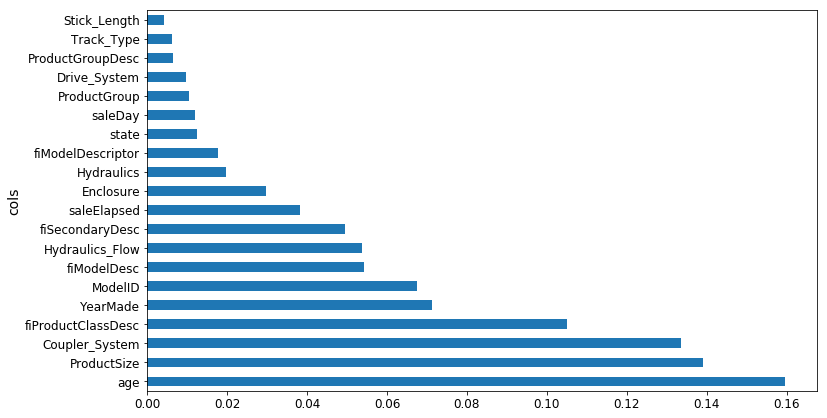

In [0]:
plot_fi(rf_feat_importance(m, X_train));

In [0]:
np.save('tmp/subs_cols.npy', np.array(df_subs.columns))

# Our final model!

In [0]:
m = RandomForestRegressor(n_estimators=160, max_features=0.5, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 6min 3s, sys: 2.75 s, total: 6min 6s
Wall time: 16.7 s
[0.08104912951128229, 0.2109679613161783, 0.9865755186304942, 0.92051576728916762, 0.9143700001430598]
